# Terry Stop Classification Model

A Terry Stop, also known as a "Stop, Question, and Frisk" or a "Stop and Frisk" is based on the Supreme Court case *Terry V. Ohio*. The court in Terry held that a stop and frisk must comply with the Fourth Amendment, meaning that the stop-and-frisk cannot be unreasonable.

![Stop and frisk](./data/th.jpg)

A reasonable stop-and-frisk is one in which a reasonably prudent office is endangered. He/she may make a reasonable search for weapons of the person believed by him to be armed and dangerous.

When an officer has a *reasonable suspicion* that an individual is armed, engaged in, or about to be engaged in criminal conduct, the office may briefly stop and detain an individual for a *pat-down*

In a traffic stop setting, the Terry condition of a lawful investigatory stop is met whenever it is lawful for the police to detain an automobile and its occupants pending inquiry into a vehicular violation. The police do not need to believe that any occupant of the vehicle is involved in criminal activity. The reasonable suspicion of criminal activities discovered during the traffic stop may give rise to a Terry stop.

## Exlporatory Data Analysis
We'll use a number of Datasets, Seattle PD and NYPD. We'll process the data and create a classification that will help predict whether an arrest was made after a Terry Stop,

### Import the required Datasets and libraries

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix
from sklearn import tree


#import the seattle PD data and print the first 5 rows
seattle_data = pd.read_csv("./data/Terry_Stops_20241018.csv")
nypd_data = pd.read_excel("./data/NYPD_terry_stops.xlsx")

seattle_data.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,-1,20150000005870,101060,Field Contact,NaN,4980,1962,F,White,...,15:12:00.0000000,-,-,-,WEST PCT 2ND W - QUEEN - PLATOON 1,N,N,-,-,-
1,26 - 35,-1,20150000089918,28823,Arrest,NaN,5143,1957,M,Black or African American,...,19:13:00.0000000,ROBBERY - CRITICAL (INCLUDES STRONG ARM),--ROBBERY - STRONG ARM,911,NaN,N,Y,East,C,C1
2,-,-1,20180000078041,463764,Arrest,NaN,6921,1978,M,Asian,...,04:27:00.0000000,TRESPASS,--WARRANT SERVICES - MISDEMEANOR,911,SOUTH PCT 3RD W - ROBERT - PLATOON 2,N,Y,South,R,R2
3,56 and Above,12770971382,20200000175799,13267969395,Arrest,-,7266,1976,M,White,...,11:17:19.0000000,ASLT - CRITICAL (NO SHOOTINGS),"--ASSAULTS, OTHER",911,WEST PCT 1ST W - KING - PLATOON 1,Y,N,West,K,K1
4,26 - 35,-1,20160000108160,141119,Offense Report,NaN,7288,1984,M,White,...,17:35:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,EAST PCT 2ND W - E/G RELIEF,N,N,East,E,E2


In [61]:
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61555 entries, 0 to 61554
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         61555 non-null  object
 1   Subject ID                61555 non-null  int64 
 2   GO / SC Num               61555 non-null  int64 
 3   Terry Stop ID             61555 non-null  int64 
 4   Stop Resolution           61555 non-null  object
 5   Weapon Type               28990 non-null  object
 6   Officer ID                61555 non-null  object
 7   Officer YOB               61555 non-null  int64 
 8   Officer Gender            61555 non-null  object
 9   Officer Race              61555 non-null  object
 10  Subject Perceived Race    61555 non-null  object
 11  Subject Perceived Gender  61555 non-null  object
 12  Reported Date             61555 non-null  object
 13  Reported Time             61555 non-null  object
 14  Initial Call Type     

In [62]:
seattle_data.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,6.155500e+04,6.155500e+04,6.155500e+04,61555.000000
mean,7.514672e+09,2.018711e+13,1.258517e+10,1984.135976
std,1.307486e+10,8.549706e+10,1.800415e+10,9.467342
min,-8.000000e+00,-1.000000e+00,2.802000e+04,1900.000000
25%,-1.000000e+00,2.017000e+13,2.413675e+05,1979.000000
50%,-1.000000e+00,2.018000e+13,5.132840e+05,1986.000000
75%,7.755940e+09,2.021000e+13,2.040625e+10,1991.000000
max,6.008468e+10,2.024000e+13,6.008639e+10,2002.000000


In [63]:
seattle_data.isna().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

* Based on the dataset description, "Arrest Flag" indicates whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS). We'll use this as our target

In [64]:
seattle_data['Arrest Flag'].value_counts()

Arrest Flag
N    54851
Y     6704
Name: count, dtype: int64

In [65]:
seattle_data['Arrest Flag'].isnull().sum()

0

In [66]:
y = seattle_data['Arrest Flag']
X = seattle_data.drop(['Terry Stop ID','Arrest Flag','Officer ID','Subject ID','GO / SC Num'], axis=1)

In [67]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=3, test_size=0.2)

In [68]:
print(f"X_train for the seattle dataset is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} colums.")
print(f"y_train for seattle dataset is a Series with {y_train.shape[0]} values.")

X_train for the seattle dataset is a DataFrame with 49244 rows and 18 colums.
y_train for seattle dataset is a Series with 49244 values.


In [69]:
X_train.dtypes

Subject Age Group           object
Stop Resolution             object
Weapon Type                 object
Officer YOB                  int64
Officer Gender              object
Officer Race                object
Subject Perceived Race      object
Subject Perceived Gender    object
Reported Date               object
Reported Time               object
Initial Call Type           object
Final Call Type             object
Call Type                   object
Officer Squad               object
Frisk Flag                  object
Precinct                    object
Sector                      object
Beat                        object
dtype: object

In [70]:
def reformat_columns(data, return_type='dataframe'):
    '''Function that reformat the columns.
    adding an underscore to the naming convention and lowering the font'''
    if isinstance(data, pd.DataFrame):
        # Reformat columns for DataFrame
        formatted_columns = data.rename(columns=lambda x: x.replace(' ', '_').lower())
        if return_type == "dataframe":
            return formatted_columns
        elif return_type == "series":
            return formatted_data.columns.to_series()
        else:
            raise ValueError("return_type must be either 'dataframe' or 'series' when data is a DataFrame.")
            
      # Check if the input is a Series
    elif isinstance(data, pd.Series):
        # Reformat the Series name if it has one
        formatted_columns = data.rename(data.name.replace(' ', '_').lower() if data.name else None)
    return formatted_columns

In [71]:
#Let's change the string style to a more conventional style
X_train = reformat_columns(X_train)
X_train.columns

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'initial_call_type', 'final_call_type', 'call_type', 'officer_squad',
       'frisk_flag', 'precinct', 'sector', 'beat'],
      dtype='object')

In [72]:
y_train = reformat_columns(y_train)
y_train.name

'arrest_flag'

In [73]:
X_test = reformat_columns(X_test)
X_test.columns

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'initial_call_type', 'final_call_type', 'call_type', 'officer_squad',
       'frisk_flag', 'precinct', 'sector', 'beat'],
      dtype='object')

In [74]:
y_test = reformat_columns(y_test)
y_test.name

'arrest_flag'

In [75]:
weapons_missing_percentage = (X_train['weapon_type'].isna().sum() / X_train.shape[0]) * 100
squad_missing_percetnage = (X_train['officer_squad'].isna().sum() / X_train.shape[0]) * 100

print(f"{weapons_missing_percentage:.2f}% of data is missing from the weapon type row")
print(f"{squad_missing_percetnage:.2f}% of data is missing from the squad row ")

52.91% of data is missing from the weapon type row
0.90% of data is missing from the squad row 


We will tackle each column and standardize them

In [76]:
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_train_numeric.columns

Index(['officer_yob'], dtype='object')

In [77]:
X_train_categorical = X_train.select_dtypes(include=['object'])
X_train_categorical.columns

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_gender',
       'officer_race', 'subject_perceived_race', 'subject_perceived_gender',
       'reported_date', 'reported_time', 'initial_call_type',
       'final_call_type', 'call_type', 'officer_squad', 'frisk_flag',
       'precinct', 'sector', 'beat'],
      dtype='object')

In [78]:
X_test_numeric = X_test.select_dtypes(exclude=['object'])
X_test_numeric.columns

Index(['officer_yob'], dtype='object')

In [79]:
X_test_categorical = X_test.select_dtypes(include=['object'])
X_test_categorical.columns

Index(['subject_age_group', 'stop_resolution', 'weapon_type', 'officer_gender',
       'officer_race', 'subject_perceived_race', 'subject_perceived_gender',
       'reported_date', 'reported_time', 'initial_call_type',
       'final_call_type', 'call_type', 'officer_squad', 'frisk_flag',
       'precinct', 'sector', 'beat'],
      dtype='object')

In [80]:
X_train_categorical['subject_age_group'].value_counts().sort_values(ascending=True)

subject_age_group
-                1798
1 - 17           1837
56 and Above     2584
46 - 55          6247
18 - 25          9355
36 - 45         11050
26 - 35         16373
Name: count, dtype: int64

In [81]:
X_train_categorical = X_train_categorical.replace('-',np.nan)
X_test_categorical = X_test_categorical.replace('-', np.nan)
X_train_categorical['subject_age_group'].isna().value_counts()

subject_age_group
False    47446
True      1798
Name: count, dtype: int64

In [82]:
X_test_categorical['subject_age_group'].isna().value_counts()

subject_age_group
False    11891
True       420
Name: count, dtype: int64

In [83]:


imputer = SimpleImputer(strategy='constant', fill_value=None)
imputer.fit(X_train_categorical)

X_train_imputed = imputer.transform(X_train_categorical)

X_test_imputed = imputer.transform(X_test_categorical)

X_train_categorical_imputer = pd.DataFrame(X_train_imputed, columns=X_train_categorical.columns, index=X_train_categorical.index)

X_test_categorical_imputer = pd.DataFrame(X_test_imputed, columns=X_test_categorical.columns, index=X_test_categorical.index)



In [84]:
X_train_categorical_imputer['subject_age_group'].isna()

37396    False
7786     False
16995    False
55912    False
31610    False
         ...  
48056    False
59011    False
11513    False
1688     False
5994     False
Name: subject_age_group, Length: 49244, dtype: bool

In [85]:
for val in X_train_categorical_imputer.columns:
    print(X_train_categorical[[val]].value_counts().sort_values(ascending=True))
    print()

subject_age_group
1 - 17                1837
56 and Above          2584
46 - 55               6247
18 - 25               9355
36 - 45              11050
26 - 35              16373
Name: count, dtype: int64

stop_resolution         
Citation / Infraction         173
Referred for Prosecution      588
Arrest                      11945
Offense Report              12621
Field Contact               23917
Name: count, dtype: int64

weapon_type                         
Personal Weapons (hands, feet, etc.)       1
Blackjack                                  1
Brass Knuckles                             1
Automatic Handgun                          2
Shotgun                                    4
Rifle                                      9
Club                                       9
Fire/Incendiary Device                    11
Firearm (unk type)                        13
None/Not Applicable                       16
Taser/Stun Gun                            20
Club, Blackjack, Brass Knuckles        

In [86]:
X_train_categorical_imputer.isna().sum()

subject_age_group           0
stop_resolution             0
weapon_type                 0
officer_gender              0
officer_race                0
subject_perceived_race      0
subject_perceived_gender    0
reported_date               0
reported_time               0
initial_call_type           0
final_call_type             0
call_type                   0
officer_squad               0
frisk_flag                  0
precinct                    0
sector                      0
beat                        0
dtype: int64

In [87]:
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  # Use -1 for unknown categories
X_train_categorical_ordinal = ordinal_enc.fit_transform(
    X_train_categorical_imputer
)

# Convert the transformed data to a DataFrame
X_train_categorical_ordinal_df = pd.DataFrame(
    X_train_categorical_ordinal, 
    columns=X_train_categorical_imputer.columns,
    index=X_train_categorical_imputer.index
)

# Concatenate the original DataFrame with the encoded column
X_train_categorical_encoded = pd.concat(
    [X_train_categorical_imputer, X_train_categorical_ordinal_df.add_suffix('_encoded')], 
    axis=1
)

X_train_categorical_encoded = X_train_categorical_encoded.drop(X_train_categorical_imputer.columns, axis=1)

X_test_categorical_ordinal = ordinal_enc.transform(X_test_imputed)

X_test_categorical_ordinal_df = pd.DataFrame(X_test_categorical_ordinal, 
                                             columns=X_test_categorical_imputer.columns,
                                             index=X_test_categorical_imputer.index)
X_test_categorical_encoded = pd.concat(
    [X_test_categorical, X_test_categorical_ordinal_df.add_suffix('_encoded')], 
    axis=1
)

X_test_categorical_encoded = X_test_categorical_encoded.drop(X_test_categorical.columns, axis=1)

X_train_categorical_encoded

C:\Users\omend\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


,subject_age_group_encoded,stop_resolution_encoded,weapon_type_encoded,officer_gender_encoded,officer_race_encoded,subject_perceived_race_encoded,subject_perceived_gender_encoded,reported_date_encoded,reported_time_encoded,initial_call_type_encoded,final_call_type_encoded,call_type_encoded,officer_squad_encoded,frisk_flag_encoded,precinct_encoded,sector_encoded,beat_encoded
37396,1.0,3.0,4.0,1.0,12.0,9.0,3.0,162.0,16535.0,47.0,44.0,0.0,187.0,1.0,5.0,18.0,52.0
7786,2.0,3.0,20.0,1.0,3.0,2.0,3.0,1354.0,5851.0,168.0,103.0,0.0,173.0,0.0,5.0,5.0,14.0
16995,3.0,0.0,20.0,1.0,12.0,2.0,3.0,1721.0,12506.0,154.0,119.0,3.0,131.0,1.0,2.0,7.0,19.0
55912,2.0,0.0,20.0,1.0,12.0,8.0,3.0,2281.0,2561.0,20.0,49.0,0.0,168.0,0.0,4.0,16.0,46.0
31610,5.0,2.0,20.0,1.0,12.0,9.0,3.0,2174.0,11146.0,29.0,25.0,3.0,241.0,0.0,7.0,14.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48056,2.0,2.0,20.0,1.0,12.0,8.0,0.0,2147.0,5206.0,30.0,120.0,3.0,115.0,0.0,2.0,11.0,32.0
59011,2.0,3.0,20.0,0.0,3.0,9.0,3.0,2034.0,13156.0,133.0,84.0,0.0,113.0,0.0,2.0,7.0,19.0
11513,2.0,0.0,20.0,1.0,3.0,9.0,0.0,712.0,2901.0,179.0,190.0,7.0,121.0,0.0,2.0,11.0,31.0
1688,2.0,0.0,20.0,1.0,12.0,9.0,0.0,1235.0,212.0,51.0,108.0,3.0,59.0,0.0,0.0,4.0,12.0


In [88]:
X_test_categorical_encoded

,subject_age_group_encoded,stop_resolution_encoded,weapon_type_encoded,officer_gender_encoded,officer_race_encoded,subject_perceived_race_encoded,subject_perceived_gender_encoded,reported_date_encoded,reported_time_encoded,initial_call_type_encoded,final_call_type_encoded,call_type_encoded,officer_squad_encoded,frisk_flag_encoded,precinct_encoded,sector_encoded,beat_encoded
36992,3.0,2.0,20.0,1.0,12.0,9.0,3.0,3014.0,13755.0,153.0,97.0,0.0,158.0,1.0,4.0,12.0,35.0
61480,3.0,2.0,20.0,0.0,12.0,2.0,3.0,909.0,18882.0,179.0,190.0,7.0,254.0,0.0,0.0,6.0,16.0
32955,5.0,0.0,20.0,1.0,12.0,9.0,3.0,1245.0,11016.0,115.0,28.0,0.0,101.0,0.0,2.0,11.0,33.0
38484,2.0,0.0,20.0,1.0,10.0,9.0,3.0,3315.0,-1.0,38.0,9.0,3.0,41.0,0.0,0.0,4.0,12.0
60377,2.0,2.0,20.0,1.0,3.0,9.0,0.0,1811.0,-1.0,129.0,35.0,0.0,231.0,0.0,7.0,14.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58266,2.0,2.0,20.0,1.0,5.0,9.0,3.0,1457.0,14764.0,179.0,190.0,7.0,48.0,0.0,8.0,19.0,54.0
46339,3.0,0.0,20.0,1.0,12.0,2.0,3.0,2163.0,-1.0,94.0,27.0,0.0,219.0,0.0,7.0,10.0,29.0
31647,5.0,2.0,20.0,0.0,10.0,9.0,3.0,311.0,16214.0,179.0,190.0,7.0,227.0,0.0,8.0,19.0,54.0
35209,3.0,2.0,20.0,1.0,12.0,8.0,3.0,2020.0,-1.0,37.0,102.0,5.0,231.0,0.0,7.0,8.0,23.0


In [89]:
X_train_categorical_encoded.dtypes

subject_age_group_encoded           float64
stop_resolution_encoded             float64
weapon_type_encoded                 float64
officer_gender_encoded              float64
officer_race_encoded                float64
subject_perceived_race_encoded      float64
subject_perceived_gender_encoded    float64
reported_date_encoded               float64
reported_time_encoded               float64
initial_call_type_encoded           float64
final_call_type_encoded             float64
call_type_encoded                   float64
officer_squad_encoded               float64
frisk_flag_encoded                  float64
precinct_encoded                    float64
sector_encoded                      float64
beat_encoded                        float64
dtype: object

We encoded the groups within 'Subject_Age_Group' Column. The numbers range from 0.0 ('Empty' or no information) to 5.0 (56 and above)

In [90]:
# def impute_missing_values(x, imputer):
#     """
#     Use the imputer to fill in all missing values in the DataFrame
#     """
#     imputed_array = imputer.transform(x)
    
#     imputed_df = pd.DataFrame(imputed_array, columns=x.columns, index=x.index)

#     return imputed_df

# One-Hot Encoder
We'll perform one-hot encoding on the categorical variables

In [91]:
# def encode_and_concat_feature_train(X_train, feature_name):
#     """
#     Transforms training data. Takes the full x DataFram and feature name, makes one-hot encoder,
#     and returns the encoder as well as the DataFrame
#     with that feature transformed into multiple columns of 1s and os.
#     """

#     #make one-hot encoder and fit to the training data
#     ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
#     single_feature_df = X_train[[feature_name]]
#     ohe.fit(single_feature_df)
    
#     #call helper function that actually encodes the feature and concats it
#     X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
#     return ohe, X_train

In [92]:
# def encode_and_concat_feature(X, feature_name, ohe):
#     """
#     Transforms a feature into multiple columns of 1s and 0s, Used in both training and testing steps. 
#     Takes in the full X dataframe, feature name, and one-hot encoder, and returns the datafram with that feature transofmred into multiple
#     columns of 1s and 0s
#     """
#     #create new one-hot encoded df based on the feature
#     single_feature_df = X[[feature_name]]
#     feature_array = ohe.transform(single_feature_df).toarray()
#     ohe_df = pd.DataFrame(feature_array, columns=ohe.get_feature_names_out(), index=X.index)

#     #drop the old feature from X and concat to the new one-hot encoded df
#     X= X.drop(feature_name, axis=1)
#     X= pd.concat([X, ohe_df], axis=1)

#     return X

In [93]:
X_train_categorical_ordinal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49244 entries, 37396 to 5994
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_age_group         49244 non-null  float64
 1   stop_resolution           49244 non-null  float64
 2   weapon_type               49244 non-null  float64
 3   officer_gender            49244 non-null  float64
 4   officer_race              49244 non-null  float64
 5   subject_perceived_race    49244 non-null  float64
 6   subject_perceived_gender  49244 non-null  float64
 7   reported_date             49244 non-null  float64
 8   reported_time             49244 non-null  float64
 9   initial_call_type         49244 non-null  float64
 10  final_call_type           49244 non-null  float64
 11  call_type                 49244 non-null  float64
 12  officer_squad             49244 non-null  float64
 13  frisk_flag                49244 non-null  float64
 14  precinct

In [94]:
X_train_df = pd.concat([X_train_categorical_encoded, X_train_numeric], axis=1)
X_train_df

,subject_age_group_encoded,stop_resolution_encoded,weapon_type_encoded,officer_gender_encoded,officer_race_encoded,subject_perceived_race_encoded,subject_perceived_gender_encoded,reported_date_encoded,reported_time_encoded,initial_call_type_encoded,final_call_type_encoded,call_type_encoded,officer_squad_encoded,frisk_flag_encoded,precinct_encoded,sector_encoded,beat_encoded,officer_yob
37396,1.0,3.0,4.0,1.0,12.0,9.0,3.0,162.0,16535.0,47.0,44.0,0.0,187.0,1.0,5.0,18.0,52.0,1981
7786,2.0,3.0,20.0,1.0,3.0,2.0,3.0,1354.0,5851.0,168.0,103.0,0.0,173.0,0.0,5.0,5.0,14.0,1979
16995,3.0,0.0,20.0,1.0,12.0,2.0,3.0,1721.0,12506.0,154.0,119.0,3.0,131.0,1.0,2.0,7.0,19.0,1979
55912,2.0,0.0,20.0,1.0,12.0,8.0,3.0,2281.0,2561.0,20.0,49.0,0.0,168.0,0.0,4.0,16.0,46.0,1977
31610,5.0,2.0,20.0,1.0,12.0,9.0,3.0,2174.0,11146.0,29.0,25.0,3.0,241.0,0.0,7.0,14.0,38.0,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48056,2.0,2.0,20.0,1.0,12.0,8.0,0.0,2147.0,5206.0,30.0,120.0,3.0,115.0,0.0,2.0,11.0,32.0,1996
59011,2.0,3.0,20.0,0.0,3.0,9.0,3.0,2034.0,13156.0,133.0,84.0,0.0,113.0,0.0,2.0,7.0,19.0,1994
11513,2.0,0.0,20.0,1.0,3.0,9.0,0.0,712.0,2901.0,179.0,190.0,7.0,121.0,0.0,2.0,11.0,31.0,1975
1688,2.0,0.0,20.0,1.0,12.0,9.0,0.0,1235.0,212.0,51.0,108.0,3.0,59.0,0.0,0.0,4.0,12.0,1974


In [95]:
X_test_df = pd.concat([X_test_categorical_encoded, X_test_numeric], axis=1)
X_test_df

,subject_age_group_encoded,stop_resolution_encoded,weapon_type_encoded,officer_gender_encoded,officer_race_encoded,subject_perceived_race_encoded,subject_perceived_gender_encoded,reported_date_encoded,reported_time_encoded,initial_call_type_encoded,final_call_type_encoded,call_type_encoded,officer_squad_encoded,frisk_flag_encoded,precinct_encoded,sector_encoded,beat_encoded,officer_yob
36992,3.0,2.0,20.0,1.0,12.0,9.0,3.0,3014.0,13755.0,153.0,97.0,0.0,158.0,1.0,4.0,12.0,35.0,1986
61480,3.0,2.0,20.0,0.0,12.0,2.0,3.0,909.0,18882.0,179.0,190.0,7.0,254.0,0.0,0.0,6.0,16.0,1984
32955,5.0,0.0,20.0,1.0,12.0,9.0,3.0,1245.0,11016.0,115.0,28.0,0.0,101.0,0.0,2.0,11.0,33.0,1976
38484,2.0,0.0,20.0,1.0,10.0,9.0,3.0,3315.0,-1.0,38.0,9.0,3.0,41.0,0.0,0.0,4.0,12.0,1995
60377,2.0,2.0,20.0,1.0,3.0,9.0,0.0,1811.0,-1.0,129.0,35.0,0.0,231.0,0.0,7.0,14.0,39.0,1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58266,2.0,2.0,20.0,1.0,5.0,9.0,3.0,1457.0,14764.0,179.0,190.0,7.0,48.0,0.0,8.0,19.0,54.0,1992
46339,3.0,0.0,20.0,1.0,12.0,2.0,3.0,2163.0,-1.0,94.0,27.0,0.0,219.0,0.0,7.0,10.0,29.0,1992
31647,5.0,2.0,20.0,0.0,10.0,9.0,3.0,311.0,16214.0,179.0,190.0,7.0,227.0,0.0,8.0,19.0,54.0,1992
35209,3.0,2.0,20.0,1.0,12.0,8.0,3.0,2020.0,-1.0,37.0,102.0,5.0,231.0,0.0,7.0,8.0,23.0,1978


## Encode the target for the train and test

In [96]:
y_train

37396    N
7786     N
16995    Y
55912    Y
31610    N
        ..
48056    N
59011    N
11513    N
1688     N
5994     N
Name: arrest_flag, Length: 49244, dtype: object

In [97]:
lab_c = LabelEncoder()

y_train_encoded = lab_c.fit_transform(y_train)

y_test_encoded = lab_c.transform(y_test)

y_train_encoded_series = pd.Series(y_train_encoded, index=y_train.index, name=y_train.name)

y_test_encoded_series = pd.Series(y_test_encoded, index=y_test.index, name=y_test.name)

y_train_encoded_series

37396    0
7786     0
16995    1
55912    1
31610    0
        ..
48056    0
59011    0
11513    0
1688     0
5994     0
Name: arrest_flag, Length: 49244, dtype: int32

0 = No, 1 = Yes

In [98]:
y_test_encoded_series

36992    0
61480    0
32955    0
38484    1
60377    0
        ..
58266    0
46339    1
31647    0
35209    0
620      0
Name: arrest_flag, Length: 12311, dtype: int32

In [99]:
correlations = {}

# Loop through each column in X_train_categorical_ordinal_df and calculate its correlation with y_train_encoded_series
for column in X_train_df.columns:
    correlations[column] = X_train_df[column].corr(y_train_encoded_series)

# Convert to a Series for easier visualization
target_correlation = pd.Series(correlations)

print(target_correlation)


subject_age_group_encoded          -0.000408
stop_resolution_encoded            -0.566434
weapon_type_encoded                -0.099031
officer_gender_encoded             -0.003478
officer_race_encoded               -0.030974
subject_perceived_race_encoded     -0.020331
subject_perceived_gender_encoded    0.021643
reported_date_encoded               0.309005
reported_time_encoded              -0.004641
initial_call_type_encoded          -0.134749
final_call_type_encoded            -0.168097
call_type_encoded                  -0.162881
officer_squad_encoded               0.020959
frisk_flag_encoded                  0.087138
precinct_encoded                   -0.016893
sector_encoded                     -0.072608
beat_encoded                       -0.072546
officer_yob                         0.134119
dtype: float64


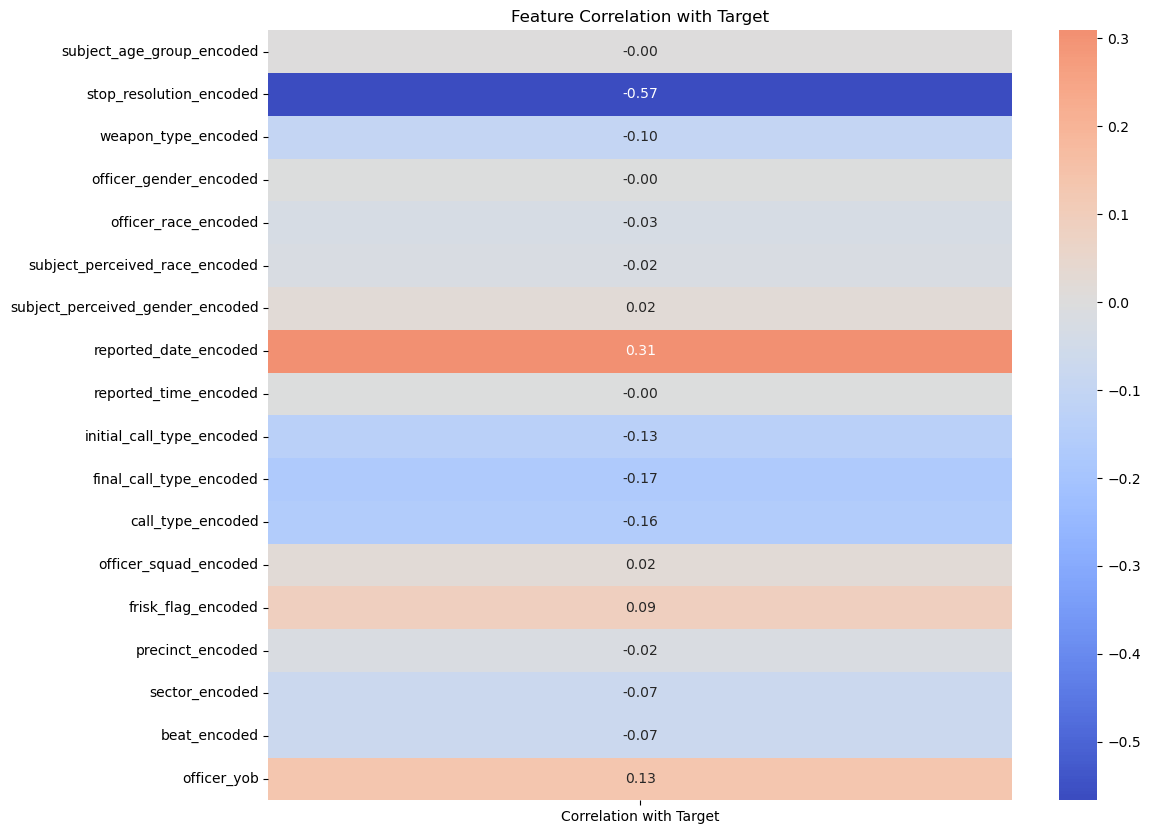

In [100]:


correlation_df = target_correlation.to_frame(name="Correlation with Target")

plt.figure(figsize=(12,10))

sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f")
plt.title("Feature Correlation with Target")
plt.show()

### Based on the heatmap. We can see that the best correlation in regards to the target is "Stop Resolution", "Reported date", "Final Call Type", "call type", and finally "weapon type"

In [102]:
baseline_model = LogisticRegression(random_state=9)

baseline_neg_log_loss_cv = cross_val_score(baseline_model,
                                         X_train_df,
                                         y_train_encoded_series,
                                         scoring="neg_log_loss",
                                          )

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

C:\Users\omend\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\omend\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.2784636144837357

In [103]:
baseline_neg_log_loss_cv

array([-0.27772566, -0.27918455, -0.2733218 , -0.29446499, -0.26762107])

In [104]:
# train_features = X_train_categorical_ordinal_df[['stop_resolution','weapon_type','reported_date','call_type','final_call_type']]
# test_features = X_test_categorical_ordinal_df[['stop_resolution','weapon_type','reported_date','call_type','final_call_type']]

In [105]:
# One-Hot Encoding on the ordinal encoded training data

ohe = OneHotEncoder(sparse_output=False, drop='first')

# Ensure only the columns without unknown values are passed to OneHotEncoder
X_train_encoder = ohe.fit_transform(X_train_df)

# Transform the test data, handling unknown categories
# X_test_categorical_ordinal = ordinal_enc.transform(X_test_categorical)

# Replace -1 with a known category or drop the rows with unknown categories
# X_test_categorical_ordinal_df = pd.DataFrame(
#     X_test_categorical_ordinal, 
#     columns=X_test_categorical.columns,
#     index=X_test_categorical.index
# )

# Optionally, replace -1 with a specific known category (e.g., 'unknown')
X_test_df = X_test_df.replace(-1, 0)  # or any valid category

# Apply One-Hot Encoding to the test data
X_test_encoder = ohe.transform(X_test_df)

# Get the encoded feature names
encoded_columns = ohe.get_feature_names_out(input_features=X_train_df.columns)

# Convert to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoder, columns=encoded_columns, index=X_train_categorical_ordinal_df.index)
X_test_encoded_df = pd.DataFrame(X_test_encoder, columns=encoded_columns, index=X_test_categorical_ordinal_df.index)

X_test_encoded_df

,subject_age_group_encoded_1.0,subject_age_group_encoded_2.0,subject_age_group_encoded_3.0,subject_age_group_encoded_4.0,subject_age_group_encoded_5.0,subject_age_group_encoded_6.0,stop_resolution_encoded_1.0,stop_resolution_encoded_2.0,stop_resolution_encoded_3.0,stop_resolution_encoded_4.0,...,officer_yob_1993,officer_yob_1994,officer_yob_1995,officer_yob_1996,officer_yob_1997,officer_yob_1998,officer_yob_1999,officer_yob_2000,officer_yob_2001,officer_yob_2002
36992,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61480,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32955,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38484,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60377,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58266,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46339,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_encoded_df)


X_test_scaled = scaler.transform(X_test_encoded_df)

X_train_scaled

array([[ 2.06492688, -0.70576103, -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865,  1.4169102 , -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865, -0.70576103,  1.85915857, ..., -0.04182656,
        -0.03433944, -0.02342202],
       ...,
       [-0.48427865,  1.4169102 , -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865,  1.4169102 , -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865, -0.70576103, -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202]])

In [107]:
X_test_scaled

array([[-0.48427865, -0.70576103,  1.85915857, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865, -0.70576103,  1.85915857, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865, -0.70576103, -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       ...,
       [-0.48427865, -0.70576103, -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865, -0.70576103,  1.85915857, ..., -0.04182656,
        -0.03433944, -0.02342202],
       [-0.48427865,  1.4169102 , -0.53787773, ..., -0.04182656,
        -0.03433944, -0.02342202]])

## Train a vanilla classfier

We will use a decision tree, since there are a large number of categorical columns that required One-hot encoding

In [108]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=3).fit(X_train_scaled, y_train_encoded_series)

### Make Predictions

In [109]:
#make predictions
y_pred = dt.predict(X_test_scaled)

In [110]:


print(f"Mean Absolute Error: {mean_absolute_error(y_test_encoded_series, y_pred)}")
print(f"Mean Squared Error: {np.sum(np.power(y_test_encoded - y_pred, 2))/len(y_test_encoded)}")
print(f"Root Squared Mean Error: {root_mean_squared_error(y_test_encoded, y_pred)}")
print(f"R-Squared: {r2_score(y_test_encoded, y_pred)}")

confus_matrix = confusion_matrix(y_test_encoded,y_pred)
print("\nConfusion Matrix")
print(confus_matrix)

Mean Absolute Error: 0.053204451303712125
Mean Squared Error: 0.053204451303712125
Root Squared Mean Error: 0.23066090111614523
R-Squared: 0.43164867103546345

Confusion Matrix
[[10691   333]
 [  322   965]]


In [111]:
# check the AUC of predictions
fpr, tpr, thresholds = roc_curve(y_test_encoded_series, y_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.8597994641626716

In [113]:


cv_scores = cross_val_score(dt, X_train_scaled, y_train_encoded_series, cv=5, scoring="roc_auc")
print(f"Cross-validated score: {cv_scores}")
print(f"Mean AUC Score: {cv_scores.mean()}")
print(f"Standard Deviation of AUC scores: {cv_scores.std()}")

MemoryError: Unable to allocate 7.18 GiB for an array with shape (39395, 24459) and data type float64

In [ ]:
# from sklearn import tree
plt.figure(figsize=(20,12), dpi=500)
tree.plot_tree(dt,
              feature_names=X_train_encoded_df.columns,
              class_names=np.unique(y_train_encoded_series).astype('str'),
              filled=True,
              rounded=True,
              max_depth=10)
plt.show()

In [ ]:
max_depth_values = np.arange(1,11)

train_aucs = []
test_aucs = []

for depth in max_depth_values:
    #Intialize predicted probabilities for training and test sets
    clf = DecisionTreeClassifier(max_depth=depth, random_state=3)
    clf.fit(X_train_encoded_df, y_train_encoded_series)
    
    # Get predicted probabilities for training and test sets
    y_train_prob = clf.predict(X_train_encoded_df)
    y_test_prob = clf.predict(X_test_encoded_df)
    # y_train_prob = clf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_prob = clf.predict_proba(X_test_encoded_df)[:,1]
    
    # Calculate FPR (False Positive Rate), TPR(True Positive Rate) and test sets using roc_curve
    fpr_train, tpr_train, _ = roc_curve(y_train_encoded_series, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_encoded_series, y_test_prob)
    
    # Calculate AUC absed on FPR and TPR using auc
    train_auc = auc(fpr_train, tpr_train)
    test_auc = auc(fpr_test, tpr_test)
    
    # Append AUC to the list
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)


# PLot the figure
plt.figure(figsize=(10,8))
plt.plot(max_depth_values, train_aucs, label="Train AUC", marker="o")
plt.plot(max_depth_values, test_aucs, label="Test AUC", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("AUC Scores")
plt.legend()
plt.show()

In [ ]:
# identify the optimal min-samples-split 
min_sample_splits_value = np.arange(0.1,1.1,0.1)
train_auc_splits = []
test_auc_splits = []

for split in min_sample_splits_value:
    clf_split = DecisionTreeClassifier(min_samples_split=split, random_state=3)
    clf_split.fit(X_train_encoded_df, y_train_encoded_series)

    y_train_probs = clf_split.predict(X_train_encoded_df)
    y_test_probs = clf_split.predict(X_test_encoded_df)
    # y_train_probs = clf_split.predict_proba(X_train_encoded_df)[:,1]
    # y_test_probs = clf_split.predict_proba(X_test_encoded_df)[:,1]

    fpr_train_split, tpr_train_split, _ = roc_curve(y_train_encoded_series, y_train_probs)
    fpr_test_split, tpr_test_split, _ = roc_curve(y_test_encoded_series, y_test_probs)

    train_auc_split = auc(fpr_train_split, tpr_train_split)
    test_auc_split = auc(fpr_test_split, tpr_test_split)
    
    train_auc_splits.append(train_auc_split)
    test_auc_splits.append(test_auc_split)


plt.figure(figsize=(10,8))
plt.plot(min_sample_splits_value, train_auc_splits, label="Train AUC Split", marker="o")
plt.plot(min_sample_splits_value, test_auc_splits, label="Test AUC Split", marker="o")
plt.xlabel("Min Sample Split")
plt.ylabel("AUC split Scores")
plt.legend()
plt.show()

In [ ]:
min_sample_leafs_values = np.arange(0.1,0.6,0.1)
train_auc_leafs = []
test_auc_leafs = []

for leaf in min_sample_leafs_values:
    #instantiate the classifier
    clf_leaf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=3)
    clf_leaf.fit(X_train_encoded_df, y_train_encoded_series)

    y_train_leaf_pred_prob = clf_leaf.predict(X_train_encoded_df)
    y_test_leaf_pred_prob = clf_leaf.predict(X_test_encoded_df)

    # predict probabilities
    # y_train_leaf_pred_prob = clf_leaf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_leaf_pred_prob = clf_leaf.predict_proba(X_test_encoded_df)[:,1]

    # get the false positive and true positive values
    fpr_train_leaf, tpr_train_leaf, _ = roc_curve(y_train_encoded_series, y_train_leaf_pred_prob)
    fpr_test_leaf, tpr_test_leaf, _ = roc_curve(y_test_encoded_series, y_test_leaf_pred_prob)

    # Get the AUC
    train_auc_leaf = auc(fpr_train_leaf, tpr_train_leaf)
    test_auc_leaf = auc(fpr_test_leaf, tpr_test_leaf)

    train_auc_leafs.append(train_auc_leaf)
    test_auc_leafs.append(test_auc_leaf)

plt.figure(figsize=(12,8))
plt.plot(min_sample_leafs_values, train_auc_leafs, label="Train Leafs", marker="o")
plt.plot(min_sample_leafs_values, test_auc_leafs, label="Test Leafs", marker="o")
plt.xlabel("Min Sample Leafs")
plt.ylabel("Leaf Scores")
plt.legend()
plt.show()


In [ ]:
# #Max features

# max_feature_values = np.arange(1,X_train_encoded_df.shape[1] + 1, 1000)

# train_features = []
# test_features = []

# for feature in max_feature_values:
#     clf_features = DecisionTreeClassifier(max_features=feature, random_state=3)
#     clf_features.fit(X_train_encoded_df, y_train_encoded_series)

#     y_train_feature_prob = clf_features.predict_proba(X_train_encoded_df)[:,1]
#     y_test_feature_prob = clf_features.predict_proba(X_test_encoded_df)[:,1]

#     fpr_train_feature, tpr_train_feature, _ = roc_curve(y_train_encoded_series, y_train_feature_prob)
#     fpr_test_feature, tpr_test_feature, _ = roc_curve(y_test_encoded_series, y_test_feature_prob)

#     train_auc_feature = auc(fpr_train_feature, tpr_train_feature)
#     test_auc_feature = auc(fpr_test_feature, tpr_test_feature)

#     train_features.append(train_auc_feature)
#     test_features.append(test_auc_feature)

# plt.figure(figsize=(15,10))
# plt.plot(max_feature_values, train_features, label="Train Feauters", marker="o")
# plt.plot(max_feature_values, test_features, label="Test Feauters", marker="o")
# plt.xlabel("Max Features")
# plt.ylabel("Features")
# plt.legend()
# plt.show()

In [ ]:
# One-Hot Encoding on the ordinal encoded training data
train_features = X_train_categorical_ordinal_df[['stop_resolution','weapon_type','reported_date','call_type','final_call_type']]
ohe2 = OneHotEncoder(sparse_output=False, drop='first')

# Ensure only the columns without unknown values are passed to OneHotEncoder
X_train_encoder2 = ohe2.fit_transform(train_features)

# # Transform the test data, handling unknown categories
# X_test_categorical_ordinal = ordinal_enc.transform(X_test_categorical)

# # Replace -1 with a known category or drop the rows with unknown categories
# X_test_categorical_ordinal_df = pd.DataFrame(
#     X_test_categorical_ordinal, 
#     columns=X_test_categorical.columns,
#     index=X_test_categorical.index
# )

# Optionally, replace -1 with a specific known category (e.g., 'unknown')
X_test_categorical_ordinal_df2 = X_test_categorical_ordinal_df.replace(-1, 0)  # or any valid category

test_features = X_test_categorical_ordinal_df2[['stop_resolution','weapon_type','reported_date','call_type','final_call_type']]

# Apply One-Hot Encoding to the test data
X_test_encoder2 = ohe2.transform(test_features)

# Get the encoded feature names
encoded_columns2 = ohe.get_feature_names_out(input_features=train_features.columns)

# Convert to DataFrames
X_train_encoded_df2 = pd.DataFrame(X_train_encoder, columns=encoded_columns, index=X_train_categorical_ordinal_df.index)
X_test_encoded_df2 = pd.DataFrame(X_test_encoder, columns=encoded_columns, index=X_test_categorical_ordinal_df.index)

X_test_encoded_df2

In [ ]:
scaler2 = StandardScaler()

train_scaler2 = scaler2.fit_transform(X_train_encoded_df2)

test_scaler2 = scaler.transform(X_test_encoder_df2)

train_scaler2

In [84]:
dt2 = DecisionTreeClassifier(criterion='entropy', random_state=3).fit(X_train_encoded_df2, y_train_encoded_series)

y_pred2 = dt2.predict(X_test_encoded_df2)


print(f"Mean Absolute Error: {mean_absolute_error(y_test_encoded_series, y_pred2)}")
print(f"Mean Squared Error: {np.sum(np.power(y_test_encoded - y_pred2, 2))/len(y_test_encoded)}")
print(f"Root Squared Mean Error: {root_mean_squared_error(y_test_encoded, y_pred2)}")
print(f"R-Squared: {r2_score(y_test_encoded, y_pred2)}")

confus_matrix = confusion_matrix(y_test_encoded,y_pred)
print("\nConfusion Matrix")
print(confus_matrix)

Mean Absolute Error: 0.052879538623994804
Mean Squared Error: 0.052879538623994804
Root Squared Mean Error: 0.22995551444571796
R-Squared: 0.4351195188459338

Confusion Matrix
[[10511   513]
 [  374   913]]


In [85]:
# check the AUC of predictions
fpr2, tpr2, thresholds2 = roc_curve(y_test_encoded_series, y_pred2)
roc_auc = auc(fpr2,tpr2)
roc_auc

0.9155703442260046

Cross-validated score: [1.        1.        0.9994817 1.        1.       ]
Mean AUC Score: 0.9998963400643703
Standard Deviation of AUC scores: 0.00020731987125923725


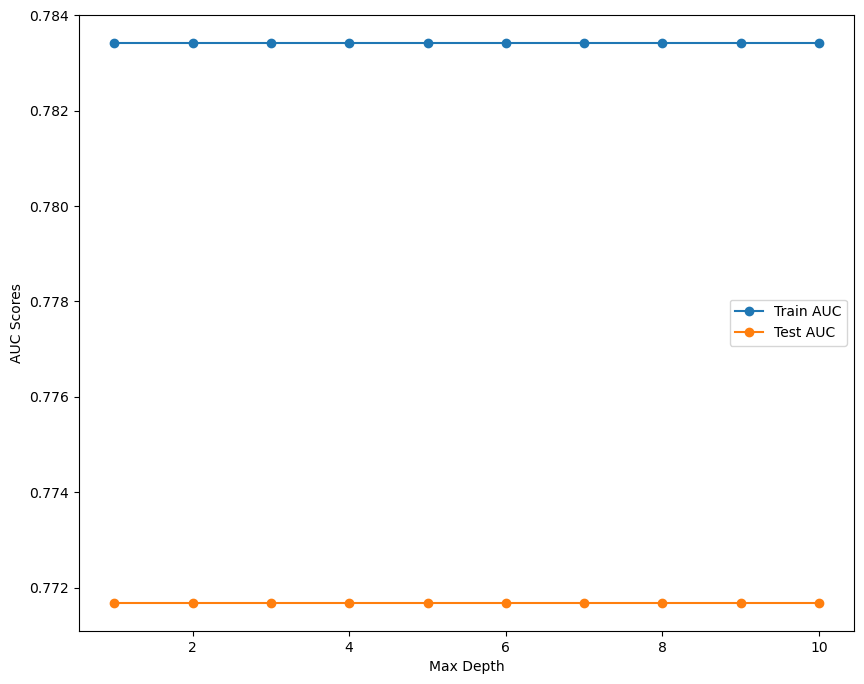

In [88]:
# max_depth_values = np.arange(1,11)

train_aucs2 = []
test_aucs2 = []

for depth in max_depth_values:
    #Intialize predicted probabilities for training and test sets
    clf2 = DecisionTreeClassifier(max_depth=depth, random_state=3)
    clf2.fit(X_train_encoded_df2, y_train_encoded_series)
    
    # Get predicted probabilities for training and test sets
    y_train_prob2 = clf2.predict(X_train_encoded_df2)
    y_test_prob2 = clf2.predict(X_test_encoded_df2)
    # y_train_prob = clf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_prob = clf.predict_proba(X_test_encoded_df)[:,1]
    
    # Calculate FPR (False Positive Rate), TPR(True Positive Rate) and test sets using roc_curve
    fpr_train2, tpr_train2, _ = roc_curve(y_train_encoded_series, y_train_prob2)
    fpr_test2, tpr_test2, _ = roc_curve(y_test_encoded_series, y_test_prob2)
    
    # Calculate AUC absed on FPR and TPR using auc
    train_auc2 = auc(fpr_train2, tpr_train2)
    test_auc2 = auc(fpr_test2, tpr_test2)
    
    # Append AUC to the list
    train_aucs2.append(train_auc)
    test_aucs2.append(test_auc)


# PLot the figure
plt.figure(figsize=(10,8))
plt.plot(max_depth_values, train_aucs2, label="Train AUC", marker="o")
plt.plot(max_depth_values, test_aucs2, label="Test AUC", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("AUC Scores")
plt.legend()
plt.show()

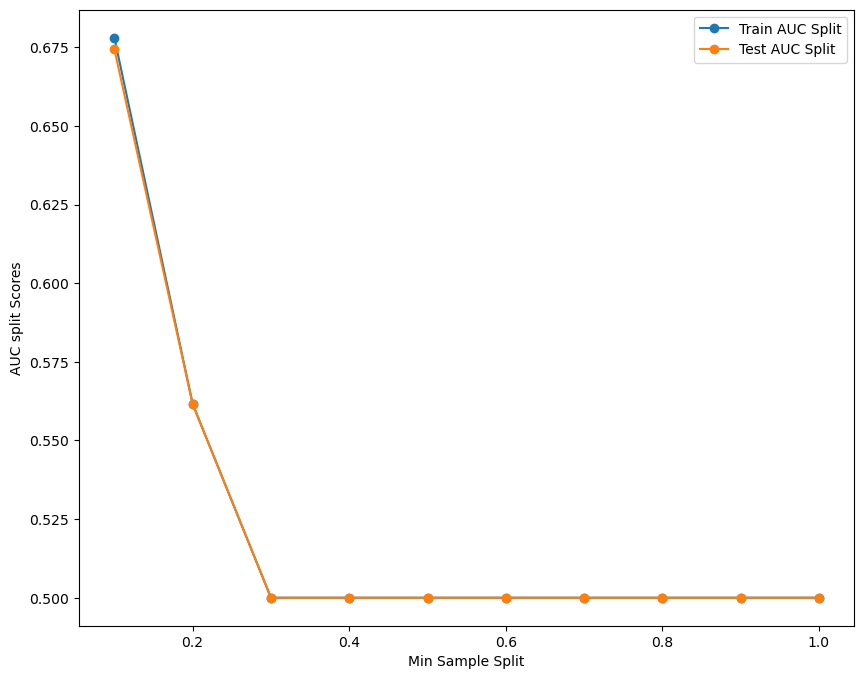

In [90]:
# identify the optimal min-samples-split 
# min_sample_splits_value = np.arange(0.1,1.1,0.1)
train_auc_splits2 = []
test_auc_splits2 = []

for split in min_sample_splits_value:
    clf_split2 = DecisionTreeClassifier(min_samples_split=split, random_state=3)
    clf_split2.fit(X_train_encoded_df2, y_train_encoded_series)

    y_train_probs2 = clf_split2.predict(X_train_encoded_df2)
    y_test_probs2 = clf_split2.predict(X_test_encoded_df2)
    # y_train_probs = clf_split.predict_proba(X_train_encoded_df)[:,1]
    # y_test_probs = clf_split.predict_proba(X_test_encoded_df)[:,1]

    fpr_train_split2, tpr_train_split2, _ = roc_curve(y_train_encoded_series, y_train_probs2)
    fpr_test_split2, tpr_test_split2, _ = roc_curve(y_test_encoded_series, y_test_probs2)

    train_auc_split2 = auc(fpr_train_split2, tpr_train_split2)
    test_auc_split2 = auc(fpr_test_split2, tpr_test_split2)
    
    train_auc_splits2.append(train_auc_split2)
    test_auc_splits2.append(test_auc_split2)


plt.figure(figsize=(10,8))
plt.plot(min_sample_splits_value, train_auc_splits2, label="Train AUC Split", marker="o")
plt.plot(min_sample_splits_value, test_auc_splits2, label="Test AUC Split", marker="o")
plt.xlabel("Min Sample Split")
plt.ylabel("AUC split Scores")
plt.legend()
plt.show()

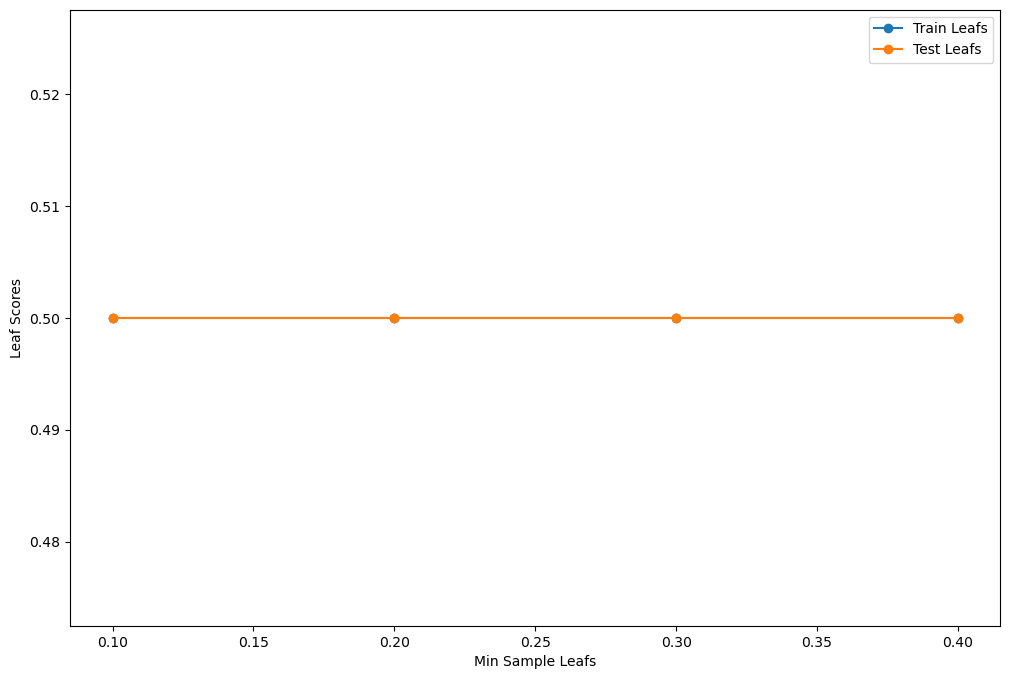

In [95]:
min_sample_leafs_values2 = np.arange(0.1,0.4,0.1)
train_auc_leafs2 = []
test_auc_leafs2 = []

for leaf in min_sample_leafs_values2:
    #instantiate the classifier
    clf_leaf2 = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=3)
    clf_leaf2.fit(X_train_encoded_df2, y_train_encoded_series)

    y_train_leaf_pred_prob2 = clf_leaf2.predict(X_train_encoded_df2)
    y_test_leaf_pred_prob2 = clf_leaf2.predict(X_test_encoded_df2)

    # predict probabilities
    # y_train_leaf_pred_prob = clf_leaf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_leaf_pred_prob = clf_leaf.predict_proba(X_test_encoded_df)[:,1]

    # get the false positive and true positive values
    fpr_train_leaf2, tpr_train_leaf2, _ = roc_curve(y_train_encoded_series, y_train_leaf_pred_prob2)
    fpr_test_leaf2, tpr_test_leaf2, _ = roc_curve(y_test_encoded_series, y_test_leaf_pred_prob2)

    # Get the AUC
    train_auc_leaf2 = auc(fpr_train_leaf2, tpr_train_leaf2)
    test_auc_leaf2 = auc(fpr_test_leaf2, tpr_test_leaf2)

    train_auc_leafs2.append(train_auc_leaf2)
    test_auc_leafs2.append(test_auc_leaf2)

plt.figure(figsize=(12,8))
plt.plot(min_sample_leafs_values2, train_auc_leafs2, label="Train Leafs", marker="o")
plt.plot(min_sample_leafs_values2, test_auc_leafs2, label="Test Leafs", marker="o")
plt.xlabel("Min Sample Leafs")
plt.ylabel("Leaf Scores")
plt.legend()
plt.show()


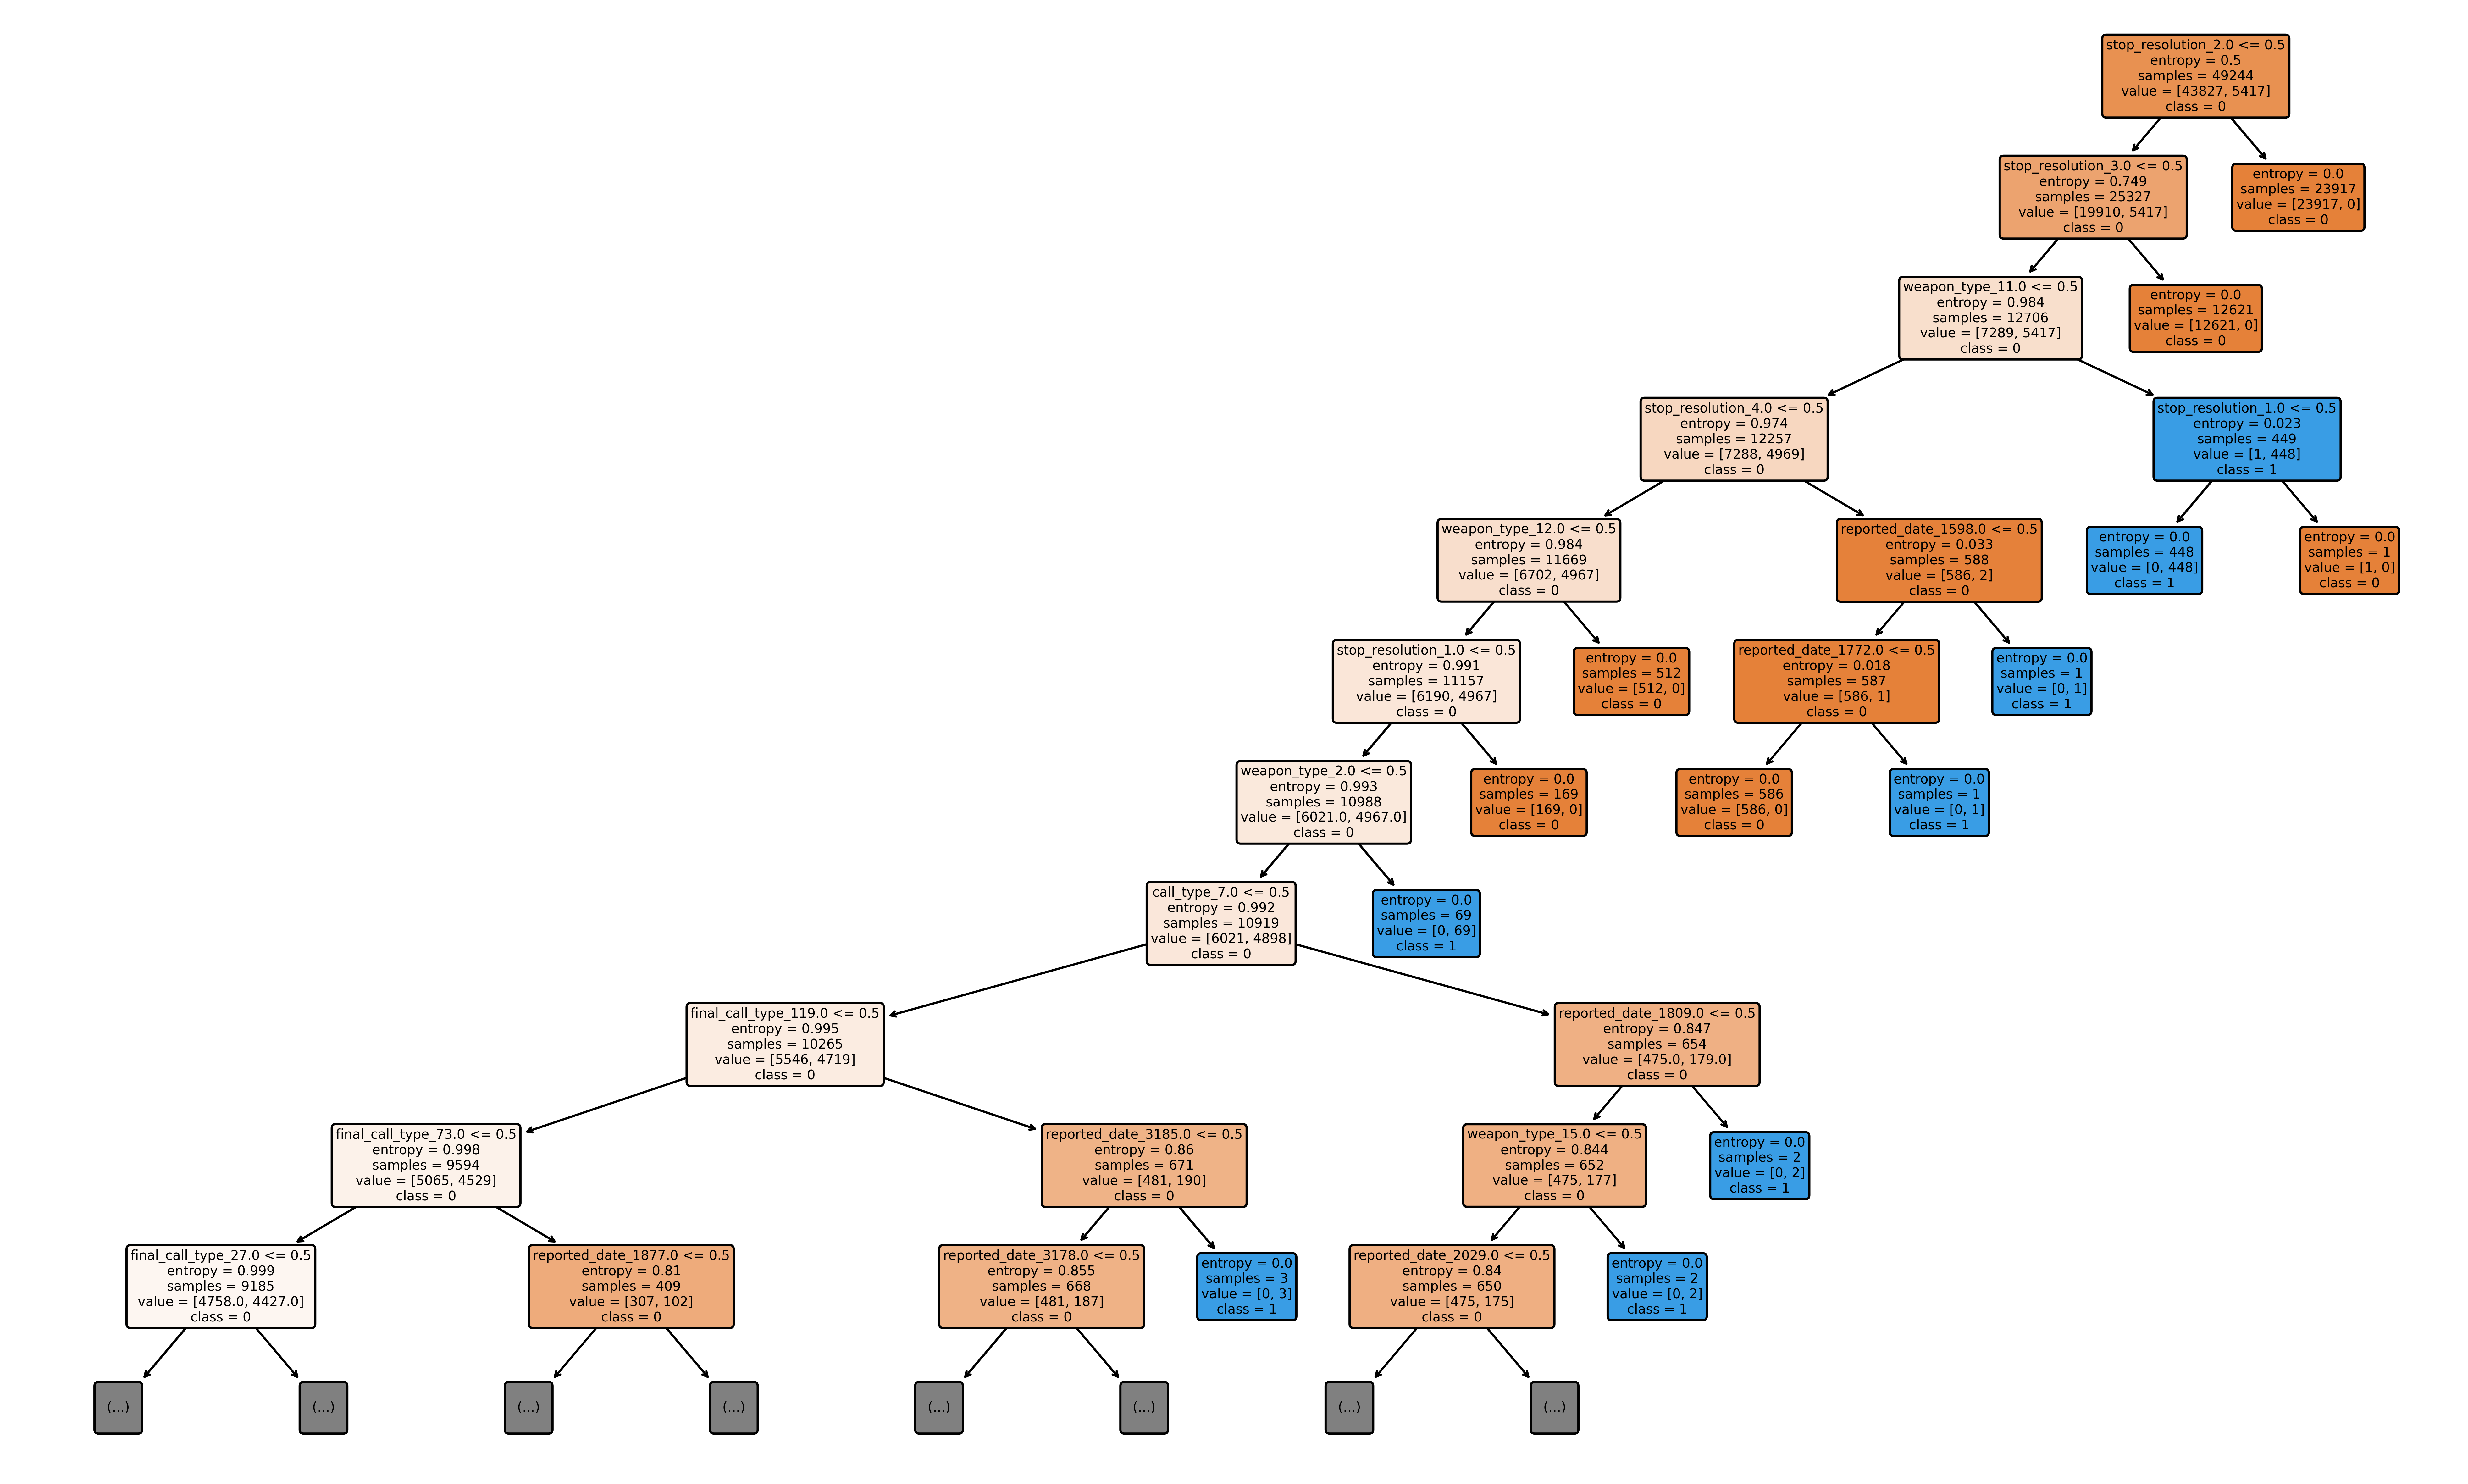

In [112]:
# from sklearn import tree
plt.figure(figsize=(20,12), dpi=500)
tree.plot_tree(dt,
              feature_names=X_train_encoded_df2.columns,
              class_names=np.unique(y_train_encoded_series).astype('str'),
              filled=True,
              rounded=True,
              max_depth=10)
plt.show()

In [124]:
X_train_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49244 entries, 37396 to 5994
Columns: 24404 entries, subject_age_group_1.0 to beat_54.0
dtypes: float64(24404)
memory usage: 9.0 GB
